## IMDB Review Classifier using Soft Attention

GA-Net code without Auxilliary Network  
Backbone network = BiLSTM or LSTM  

Normal softmax function is used instead of masked softmax

In [1]:
# !pip3 install torchtext==0.4

In [2]:
import math
import numpy as np
import pandas as pd
import pdb

import torch
import torch.nn.functional as F
import torch.distributions
import torch.optim as optim
from torch import nn 
from torch.autograd import Variable

import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

# from models.LSTM import LSTMClassifier

In [3]:
# model.py

class GANet(torch.nn.Module):
    def __init__(self, batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, aux_hidden_size = 100, backbone_hidden_size = 100, tau = 1, biDirectional_aux = False, biDirectional_backbone = False):
        super(GANet, self).__init__() 
        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 6 = (For TREC dataset)
        hidden_sie : Size of the hidden_state of the LSTM   (// Later BiLSTM)
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        --------

        """

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.aux_hidden_size = aux_hidden_size
        self.backbone_hidden_size = backbone_hidden_size 
        self.mlp_out_size = mlp_out_size
        self.biDirectional_aux = biDirectional_aux
        self.biDirectional_backbone = biDirectional_backbone
        self.tau = tau

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)

        self.backbone = BackboneNet(self.batch_size, self.backbone_hidden_size, self.embedding_length, self.biDirectional_backbone)

        if(self.biDirectional_backbone):
            self.mlp = MLP(self.backbone_hidden_size * 2, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size * 2,num_classes)
        else:
            self.mlp = MLP(self.backbone_hidden_size, self.mlp_out_size)
            self.FF = nn.Linear(self.backbone_hidden_size,num_classes)

    
    def forward(self,input_sequence, is_train = True):
        input_ = self.word_embeddings(input_sequence)
#         g_t, p_t = self.auxiliary(input_, is_train)
        out_lstm = self.backbone(input_)
        e_t = self.mlp(out_lstm)
        alpha = torch.softmax(e_t, dim = 1)
        c_t = torch.bmm(alpha.transpose(1,2), out_lstm)
        logits = self.FF(c_t)
        final_output = torch.softmax(logits, dim = -1)
        # final_output = final_output.max(2)[1]
        final_output = final_output.squeeze(1)

        return final_output, alpha

In [4]:
class BackboneNet(torch.nn.Module):
    """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        backbone_hidden_size : Size of the hidden_state of the LSTM   (* Later BiLSTM, check dims for BiLSTM *)
        embedding_length : Embeddding dimension of GloVe word embeddings
        --------
    """
    def __init__(self, batch_size, backbone_hidden_size, embedding_length, biDirectional = False, num_layers = 2):

        super(BackboneNet, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = backbone_hidden_size
        self.embedding_length = embedding_length
        self.biDirectional	= biDirectional
        self.num_layers = num_layers

        self.backbone_lstm = nn.LSTM(self.embedding_length, self.hidden_size, bidirectional = self.biDirectional, batch_first = True, num_layers = self.num_layers)   # Dropout  

    def forward(self, input_sequence, batch_size=None):
        out_lstm, (final_hidden_state, final_cell_state) = self.backbone_lstm(input_sequence)   # ouput dim: ( batch_size x seq_len x hidden_size )
        return out_lstm


In [5]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.ff_1 = nn.Linear(self.input_dim, self.output_dim)
        self.relu = nn.ReLU()
        self.ff_2 = nn.Linear(self.output_dim,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        out_1 = self.ff_1(x)
        out_relu = self.relu(out_1)
        out_2 = self.ff_2(out_relu)
        out_sigmoid = self.sigmoid(out_2)

        return out_sigmoid 

In [6]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, optim, train_iter, epoch, batch_size):
    total_epoch_loss = 0
    total_epoch_acc = 0
    # model.cuda()
#     optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] is not batch_size):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction, alpha = model(text, is_train = True)
        # print("prediction = ", prediction.shape)
        # print("target = ", target.shape)
        # print("prediction = ", prediction)
        # print("target = ", target)

        # Defualt - Cross entropy loss funtion
        loss = loss_fn(prediction, target)
        
        # print("loss = ", loss)
        
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        # if steps % 10 == 0:
            # print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
            # break
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    total_attention =  0
    total_samples = 0 
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] is not 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction, alpha = model(text, is_train = False)
            # Sanity check
            # print("Test Prediction: ", prediction)
            
            # Defualt - Cross entropy loss funtion
            loss =  loss_fn(prediction, target)
            
            if math.isnan(loss.item()):
                print(prediction, target)
            
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
            
    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)

In [7]:
# data.py
def load_IMDB_data(batch_size= 32, embedding_length = 100):
    # set up fields
    tokenize = lambda x: x.split()
    TEXT = data.Field(sequential=True, tokenize=tokenize, lower=True, include_lengths=True, batch_first=True, fix_length=100)
    # LABEL = data.LabelField()
    LABEL = data.LabelField(dtype=torch.float)

    # make splits for data
    train, test = datasets.IMDB.splits(TEXT, LABEL)
    train, valid = train.split() 
    
    # build the vocabulary
    TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=embedding_length))
    LABEL.build_vocab(train)
    print(LABEL.vocab.__dict__)

    # make iterator for splits
    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
      (train, valid, test), batch_size= batch_size, device=0)

    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter

In [8]:
# main.py
TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_IMDB_data()

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


{'freqs': Counter({'pos': 8779, 'neg': 8721}), 'itos': ['pos', 'neg'], 'unk_index': None, 'stoi': defaultdict(None, {'pos': 0, 'neg': 1}), 'vectors': None}


In [9]:
# Over-writing the loss function to simple cross entropy loss
loss_fn = F.cross_entropy

learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 100
num_classes = 2
mlp_out_size = 32
weights = word_embeddings
aux_hidden_size = 100
batch_hidden_size = 100
tau = 1

model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, biDirectional_backbone=True)
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))

In [19]:
# torch.save(model.state_dict(), "IMDB_Soft_Attn_100_final")

In [11]:
# training_stats.to_csv("IMDB_Soft_Attn_100.csv")

In [12]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optim.state_dict():
#     print(var_name, "\t", optim.state_dict()[var_name])

In [20]:
loaded_model = GANet(batch_size, num_classes, mlp_out_size, vocab_size, embedding_length, weights, tau= tau, biDirectional_aux=True, biDirectional_backbone=True)
loaded_model.load_state_dict(torch.load('IMDB_Soft_Attn_100_final'))
loaded_model.eval()

GANet(
  (word_embeddings): Embedding(202771, 100)
  (backbone): BackboneNet(
    (backbone_lstm): LSTM(100, 100, num_layers=2, batch_first=True, bidirectional=True)
  )
  (mlp): MLP(
    (ff_1): Linear(in_features=200, out_features=32, bias=True)
    (relu): ReLU()
    (ff_2): Linear(in_features=32, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
  (FF): Linear(in_features=200, out_features=2, bias=True)
)

In [10]:
num_bad_epochs = 0
epoch = 0
least_loss = float('inf')
training_stats = pd.DataFrame(columns=['Epoch', 'Train_Loss', 'Train_Acc', 'Val_Loss', 'Val_Acc'])

while(True):
    train_loss, train_acc = train_model(model, optim, train_iter, epoch, batch_size)
    val_loss, val_acc = eval_model(model, valid_iter) 
    print(f'Epoch: {epoch+1:02}')
    if val_loss < least_loss:
        least_loss = val_loss
        num_bad_epochs = 0
        print("*** Least validation loss")
        torch.save(model.state_dict(), "IMDB_Soft_Attn_100")
    else:
        num_bad_epochs += 1
#     print(f'Epoch: {epoch+1:2}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
    print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%') 
    print(f'Val Loss: {val_loss:3f}, Val Acc: {val_acc:.2f}%')
    print("-------------")
    
    training_stats = training_stats.append(
        pd.Series([epoch+1, train_loss, train_acc, val_loss, val_acc], index=training_stats.columns), 
        ignore_index=True)
#     if num_bad_epochs >= 10:
#         break
        
    epoch += 1
    if epoch == 100:
        break

Epoch: 01
*** Least validation loss
Train Loss: 0.603, Train Acc: 67.57%
Val Loss: 0.543198, Val Acc: 74.75%
-------------
Epoch: 02
*** Least validation loss
Train Loss: 0.477, Train Acc: 82.64%
Val Loss: 0.532478, Val Acc: 76.20%
-------------
Epoch: 03
Train Loss: 0.414, Train Acc: 89.51%
Val Loss: 0.547901, Val Acc: 75.12%
-------------
Epoch: 04
*** Least validation loss
Train Loss: 0.382, Train Acc: 92.82%
Val Loss: 0.521762, Val Acc: 77.85%
-------------
Epoch: 05
Train Loss: 0.364, Train Acc: 94.57%
Val Loss: 0.532190, Val Acc: 76.72%
-------------
Epoch: 06
*** Least validation loss
Train Loss: 0.355, Train Acc: 95.58%
Val Loss: 0.521062, Val Acc: 78.16%
-------------
Epoch: 07
Train Loss: 0.351, Train Acc: 96.01%
Val Loss: 0.534808, Val Acc: 76.74%
-------------
Epoch: 08
Train Loss: 0.345, Train Acc: 96.54%
Val Loss: 0.528122, Val Acc: 77.41%
-------------
Epoch: 09
Train Loss: 0.344, Train Acc: 96.66%
Val Loss: 0.554390, Val Acc: 74.89%
-------------
Epoch: 10
Train Loss: 0

Epoch: 85
Train Loss: 0.324, Train Acc: 98.66%
Val Loss: 0.519634, Val Acc: 78.35%
-------------
Epoch: 86
Train Loss: 0.324, Train Acc: 98.65%
Val Loss: 0.520698, Val Acc: 78.28%
-------------
Epoch: 87
Train Loss: 0.324, Train Acc: 98.67%
Val Loss: 0.519723, Val Acc: 78.43%
-------------
Epoch: 88
Train Loss: 0.324, Train Acc: 98.67%
Val Loss: 0.519515, Val Acc: 78.36%
-------------
Epoch: 89
Train Loss: 0.324, Train Acc: 98.67%
Val Loss: 0.519470, Val Acc: 78.39%
-------------
Epoch: 90
Train Loss: 0.324, Train Acc: 98.67%
Val Loss: 0.519657, Val Acc: 78.40%
-------------
Epoch: 91
Train Loss: 0.324, Train Acc: 98.69%
Val Loss: 0.520045, Val Acc: 78.36%
-------------
Epoch: 92
Train Loss: 0.324, Train Acc: 98.69%
Val Loss: 0.519917, Val Acc: 78.35%
-------------
Epoch: 93
Train Loss: 0.324, Train Acc: 98.69%
Val Loss: 0.519801, Val Acc: 78.35%
-------------
Epoch: 94
Train Loss: 0.324, Train Acc: 98.69%
Val Loss: 0.519718, Val Acc: 78.36%
-------------
Epoch: 95
Train Loss: 0.324, T

In [21]:
test_loss, test_acc = eval_model(loaded_model, test_iter)
print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.2f}')

Test Loss: 0.535, Test Acc: 77.25


In [22]:
def test_sentence(test_sen):
    test_sen_list = TEXT.preprocess(test_sen)
    print(test_sen_list)
    test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
    # print(test_sen)

    test_sen = np.asarray(test_sen)
    test_sen = torch.LongTensor(test_sen)
    test_tensor = Variable(test_sen, volatile=True)

    # print(test_tensor)
    loaded_model.eval()
    prediction, alpha = loaded_model(test_tensor, is_train = False)
    print("prediction =", prediction)
#     print("g =", g_t)
    
    for i in range(len(test_sen_list)):
        print(test_sen_list[i], float(alpha[0][i][0]))
    out_class = torch.argmax(prediction)
    return out_class


''' Let us now predict the sentiment on a single sentence just for the testing purpose. '''
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen2 = "Ohh, such a ridiculous movie. Not gonna recommend it to anyone. Complete waste of time and money."
test_sen3 = "I admire Deepa Mehta and this movie is a masterpiece . I ’d recom- mend to buy this movie on DVD because it ’s a movie you might want to watch more often than just once . And trust me , you ’d still find little meaningful details after watching it several times. The characters - except for the grandmother perhaps - are all very bal- anced , no black and white . Even though you follow the story from the perspective of the two protagonists , there is also empathy for the other characters. I think the IMDb rating for the movie is far too low - probably due to its politically controversial content ."

print('------------')
x = test_sentence(test_sen1)
print(x)
print('------------')
x = test_sentence(test_sen2)
print(x)
print('------------')
x = test_sentence(test_sen3)
print(x)
print('------------')

------------
['this', 'is', 'one', 'of', 'the', 'best', 'creation', 'of', 'nolan.', 'i', 'can', 'say,', "it's", 'his', 'magnum', 'opus.', 'loved', 'the', 'soundtrack', 'and', 'especially', 'those', 'creative', 'dialogues.']
prediction = tensor([[1.0000e+00, 2.0382e-38]], grad_fn=<SqueezeBackward1>)
this 0.04583347216248512
is 0.04616454243659973
one 0.04620068892836571
of 0.03251994773745537
the 0.04598066955804825
best 0.04620719701051712
creation 0.023172136396169662
of 0.023873215541243553
nolan. 0.04620625078678131
i 0.04415389150381088
can 0.03162219747900963
say, 0.01940092258155346
it's 0.04559541493654251
his 0.04559972509741783
magnum 0.044981393963098526
opus. 0.046198125928640366
loved 0.04620957747101784
the 0.04616222903132439
soundtrack 0.04620847478508949
and 0.046206723898649216
especially 0.04578340798616409
those 0.046201933175325394
creative 0.04331861436367035
dialogues. 0.0461992472410202
tensor(0)
------------
['ohh,', 'such', 'a', 'ridiculous', 'movie.', 'not', '

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


In [24]:
test_sen = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen_list = TEXT.preprocess(test_sen)
print(test_sen_list)
test_sen = [[TEXT.vocab.stoi[x] for x in test_sen_list]]
# print(test_sen)

test_sen = np.asarray(test_sen)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen, volatile=True)

# print(test_tensor)
loaded_model.eval()
prediction, alpha = loaded_model(test_tensor, is_train = False)
print("prediction =", prediction)
#     print("g =", g_t)

for i in range(len(test_sen_list)):
    print(test_sen_list[i], float(alpha[0][i][0]))
out_class = torch.argmax(prediction)

['this', 'is', 'one', 'of', 'the', 'best', 'creation', 'of', 'nolan.', 'i', 'can', 'say,', "it's", 'his', 'magnum', 'opus.', 'loved', 'the', 'soundtrack', 'and', 'especially', 'those', 'creative', 'dialogues.']
prediction = tensor([[1.0000e+00, 2.0382e-38]], grad_fn=<SqueezeBackward1>)
this 0.04583347216248512
is 0.04616454243659973
one 0.04620068892836571
of 0.03251994773745537
the 0.04598066955804825
best 0.04620719701051712
creation 0.023172136396169662
of 0.023873215541243553
nolan. 0.04620625078678131
i 0.04415389150381088
can 0.03162219747900963
say, 0.01940092258155346
it's 0.04559541493654251
his 0.04559972509741783
magnum 0.044981393963098526
opus. 0.046198125928640366
loved 0.04620957747101784
the 0.04616222903132439
soundtrack 0.04620847478508949
and 0.046206723898649216
especially 0.04578340798616409
those 0.046201933175325394
creative 0.04331861436367035
dialogues. 0.0461992472410202


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


In [16]:
training_stats

,Epoch,Train_Loss,Train_Acc,Val_Loss,Val_Acc
0,1.0,0.603291,67.567413,0.543198,74.747340
1,2.0,0.476999,82.638254,0.532478,76.196809
2,3.0,0.413601,89.510969,0.547901,75.119681
3,4.0,0.381792,92.824497,0.521762,77.845745
4,5.0,0.364260,94.572669,0.532190,76.715426
...,...,...,...,...,...
95,96.0,0.323829,98.703154,0.519644,78.364362
96,97.0,0.323886,98.697441,0.519637,78.377660
97,98.0,0.323944,98.691728,0.519646,78.390957
98,99.0,0.323944,98.691728,0.520545,78.297872


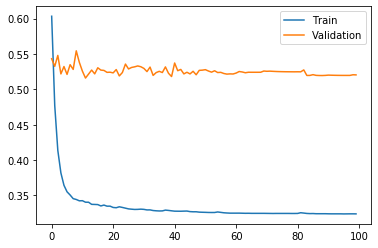

In [17]:
import matplotlib.pyplot as plt
plt.plot(training_stats['Train_Loss'], label="Train")
plt.plot(training_stats['Val_Loss'], label="Validation")
plt.legend()
plt.show()

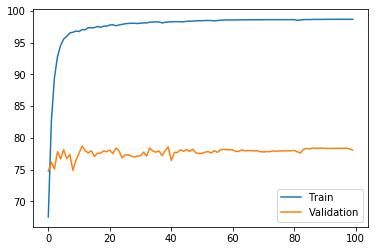

In [18]:
plt.plot(training_stats['Train_Acc'], label="Train")
plt.plot(training_stats['Val_Acc'], label="Validation")
plt.legend()
plt.show()